In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import math
from sklearn.metrics import average_precision_score, precision_recall_curve

from ete3 import NCBITaxa
from Bio import SeqIO
import taxoniq
import marisa_trie

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

### Bulk Analysis of Primary Benchmark results

This notebook focuses on the accuracy-related metrics from the Primary Benchmark (UnambiguouslyMapped at ATCC datasets). It generates **Figure S3** and **Figure 2B/2C**.

In [54]:
def plot_filtered_spearman2(input_data, cdb):
    input_data['log_'+cdb+'_bpm_new'] = np.log(input_data[cdb+'_bpm_new'] + 1)
    input_data['log_'+cdb+'_bpm_old'] = np.log(input_data[cdb+'_bpm_old'] + 1)
    
    cdb_color_dict = {'nt': official_colors[5], 'nr': official_colors[11]}

    input_data2 = input_data[input_data['nt_bpm_new'] >= 10]
    input_data3 = input_data2[input_data2['nr_bpm_new'] >= 1]
    
    plt.figure(figsize = (5,5))
    plt.scatter(input_data['log_' + cdb + '_bpm_old'], input_data['log_' + cdb + '_bpm_new'], alpha = .4, color = 'lightgrey')
    plt.scatter(input_data3['log_' + cdb + '_bpm_old'], input_data3['log_' + cdb + '_bpm_new'], alpha = .6, color = cdb_color_dict[cdb])
    plt.title(cdb + ': ' + old_taxon_counts.split('/')[-1])

    total_spearman = stats.spearmanr(input_data[cdb + '_bpm_old'], input_data[cdb + '_bpm_new'])[0]
    filtered_spearman = stats.spearmanr(input_data3[cdb + '_bpm_old'], input_data3[cdb + '_bpm_new'])[0] 

    plt.text(x = 0.05, y = 11.4, s = "Total Spearman Correlation: " + str(np.round(total_spearman,2)), color='black')
    plt.text(x = 0.05, y = 10.6, s = "QC Filtered Spearman Correlation: " + str(np.round(filtered_spearman,2)), color='black')    
    plt.xlabel("Log( bPM ) - Uncompressed DB")
    plt.ylabel("Log( bPM ) - Compressed DB")
    plt.show()

In [55]:
def generate_metrics(old_taxon_counts, new_taxon_counts, gold_standard, known_sp, current_db, show_plots = True):

    '''
    This function generates all the metrics that we'll be using to assess differences between OLD and NEW sample runs.
    Metrics: Correlation, % Increase in Taxa, L2 Norm, Taxon counts
    '''

    old_df = pd.read_csv(old_taxon_counts)
    new_df = pd.read_csv(new_taxon_counts)
    try:
        #print("attempt to read GS")
        #print(gold_standard)
        gs = pd.read_csv(gold_standard, sep='\t')
    except:
        gs = None

    # select only the species-level taxon hits
    old_df = old_df[old_df.tax_level == 1][['tax_id', 'name', 'nt_bpm', 'nt_contigs', 'nr_bpm']]
    new_df = new_df[new_df.tax_level == 1][['tax_id', 'name', 'nt_bpm', 'nt_contigs', 'nr_bpm']]
  
    full_df = pd.merge(left = old_df, right = new_df, how='outer', on='tax_id', suffixes = ['_old', '_new'])
    
    full_df.dropna(subset=[(current_db+'_bpm_old'), (current_db+'_bpm_new')], how='all', inplace=True)
    full_df['log_'+current_db+'_bpm_old'] = np.log(full_df[current_db+'_bpm_old'] + 1)
    full_df['log_'+current_db+'_bpm_new'] = np.log(full_df[current_db+'_bpm_new'] + 1)

    full_df.sort_values(by=current_db+'_bpm_old', ascending = False, inplace=True)
    
    full_df.fillna(0, inplace=True)
    full_df['diff'] = full_df[current_db+'_bpm_old'] - full_df[current_db+'_bpm_new']
    full_df['max_' + current_db + '_bpm'] = full_df[[current_db+'_bpm_old', current_db+'_bpm_new']].max(axis=1)
    full_df['perc_diff'] = full_df['diff']/full_df['max_' + current_db+ '_bpm']

    full_df.sort_values(by='diff', inplace=True)
    top_diffs = full_df.head(5)
    bottom_diffs = full_df.tail(5)
    
    # optionally, generate scatterplots showing the taxon abundances of OLD v. NEW samples
    if(show_plots):
        plot_filtered_spearman2(full_df, current_db)
    
    
    new_organisms_df = full_df[full_df.nt_bpm_old == 0]
    new_organisms_df.sort_values(by=current_db + '_bpm_new', ascending = False, inplace=True)
    
    #overall correlation
    sc_total = np.round((stats.spearmanr(full_df[current_db + '_bpm_old'], full_df[current_db + '_bpm_new']))[0], 2)
    pc_total = np.round((stats.pearsonr(full_df[current_db + '_bpm_old'], full_df[current_db + '_bpm_new']))[0], 2)
    
    # correlation when removing the taxa that are new low-abundance hits -- 
    #    this being higher than the total correlation, means that the increase in "new taxa" (false-positives) is driving some of the spearman deviation
    full_df2 = full_df[full_df.nt_bpm_new >= 10] 
    full_df3 = full_df2[full_df2.nr_bpm_new >= 1]
    sc_top =np.round((stats.spearmanr(full_df3[current_db + '_bpm_old'], full_df3[current_db + '_bpm_new']))[0], 2)
    pc_top =np.round((stats.pearsonr(full_df3[current_db + '_bpm_old'], full_df3[current_db + '_bpm_new']))[0], 2)
    
    #sc_total_norm = spearman correlation of the normalized values
    sc_total_norm = np.round((stats.spearmanr(full_df[current_db + '_bpm_old']/sum(full_df[current_db + '_bpm_old']), 
                                         full_df[current_db + '_bpm_new']/sum(full_df[current_db + '_bpm_new'])))[0], 2)
    
    #l2_total = np.linalg.norm(np.log10(full_df[current_db + '_bpm_old']+1) - np.log10(full_df[current_db + '_bpm_new']+1))    
    l2_total = math.dist(full_df[current_db + '_bpm_old']/sum(full_df[current_db + '_bpm_old']), 
                         full_df[current_db + '_bpm_new']/sum(full_df[current_db + '_bpm_new'])) 
    
    # AUPR = the AUPR when taking the OLD results as the baseline.
    # https://sinyi-chou.github.io/python-sklearn-precision-recall/
    # average_precision = average_precision_score(baseline, new)
    aupr = average_precision_score(full_df[current_db + '_bpm_old'] > 0, 
                                                full_df[current_db + '_bpm_new']/sum(full_df[current_db + '_bpm_new']))
    
    res = {}
    for i in [0, 10, 100, 1000]:
        res[str(i)] = {}
        res[str(i)]['new'] = (full_df[current_db + '_bpm_new'] > i).sum()
        res[str(i)]['old'] = (full_df[current_db + '_bpm_old'] > i).sum()

    res_df = pd.DataFrame.from_dict(res, orient='index')

    if(show_plots):
        res_df.plot.bar()
        plt.title("Total Count of Hits, bPM > Threshold")
        plt.show()

    new_taxon_count = res['0']['new']
    old_taxon_count = res['0']['old']
    percent_increase = np.round(((new_taxon_count - old_taxon_count)/old_taxon_count)*100, 2)

    new_taxon_count_f = res['10']['new']
    old_taxon_count_f = res['10']['old']
    percent_increase_f = np.round(((new_taxon_count_f - old_taxon_count_f)/old_taxon_count_f)*100, 2)
    
    aupr_gs_new = 0 #default if not gold standard
    aupr_gs_old = 0
    # Do analysis as compared to a gold standard: NEW v. GS and OLD v. GS, then compare the change in metric
    if 'XXXX' not in gold_standard: 
        # we do have a gold standard file for this, so should run analysis
        full_df_gs_old = pd.merge(left = old_df, right = gs, how='outer', on='tax_id', suffixes = ['_old', '_gs'])
        full_df_gs_old = full_df_gs_old[[current_db + '_bpm','abs_abundance', 'tax_id', 'name', 'tax_name']]
        full_df_gs_old.fillna(0, inplace=True)
        aupr_old = average_precision_score(full_df_gs_old['abs_abundance'] > 0, 
                                                full_df_gs_old[current_db + '_bpm'])
        
        l2_old = math.dist(full_df_gs_old['abs_abundance']/sum(full_df_gs_old['abs_abundance']), 
                         full_df_gs_old[current_db + '_bpm']/sum(full_df_gs_old[current_db + '_bpm'])) 
        
        full_df_gs_new = pd.merge(left = new_df, right = gs, how='outer', on='tax_id', suffixes = ['_new', '_gs'])
        full_df_gs_new = full_df_gs_new[[current_db + '_bpm','abs_abundance', 'tax_id', 'name', 'tax_name']]
        full_df_gs_new.fillna(0, inplace=True)
        aupr_new = average_precision_score(full_df_gs_new['abs_abundance'] > 0, 
                                                full_df_gs_new[current_db + '_bpm'])
        l2_new = math.dist(full_df_gs_new['abs_abundance']/sum(full_df_gs_new['abs_abundance']), 
                         full_df_gs_new[current_db + '_bpm']/sum(full_df_gs_new[current_db + '_bpm']))
        
        delta_aupr = aupr_new - aupr_old
        print("delta_aupr: " + str(delta_aupr))
        print("aupr new: " + str(aupr_new))
        delta_l2 = l2_new - l2_old
        aupr_gs_old = aupr_old
        aupr_gs_new = aupr_new
    else:
        # no gold standard file available, so don't run this analysis
        print("NO GOLD STANDARD FOR: " + gold_standard)
        delta_aupr = 0
        delta_l2 = 0
        
    if 'XXXX' not in known_sp:
        # we DO have a known_sp, so DO run this analysis
        print(known_sp)
        try:
            known_sp_proportion_old = full_df[full_df.name_old == known_sp][current_db + '_bpm_old'].iloc[0] / np.sum(full_df[current_db + '_bpm_old'])
        except:
            known_sp_proportion_old = 0
        try:
            known_sp_proportion_new = full_df[full_df.name_old == known_sp][current_db + '_bpm_new'].iloc[0] / np.sum(full_df[current_db + '_bpm_new'])
        except:
            known_sp_proportion_new = 0
        print(known_sp_proportion_old)
        print(known_sp_proportion_new)
        delta_prop = known_sp_proportion_new - known_sp_proportion_old
    else:
        print("hello")
        known_sp_proportion_old = 0
        known_sp_proportion_new = 0
        delta_prop = 0
        # we don't have a known_sp, so don't run this analysis
 
    

    return({'sc_total': sc_total, 
           'pc_total': sc_total, 
           'sc_top': sc_top, 
           'pc_top': pc_top, 
            'sc_total_norm': sc_total_norm,
            'l2_total': l2_total,
            'aupr': aupr,
           'new_taxon_count': new_taxon_count, 
           'old_taxon_count': old_taxon_count, 
           'percent_increase': percent_increase,
           'new_taxon_count_f': new_taxon_count_f, 
           'old_taxon_count_f': old_taxon_count_f, 
           'percent_increase_f': percent_increase_f,
           'delta_aupr': delta_aupr,
           'delta_l2': delta_l2,
           'known_sp_prop_old': known_sp_proportion_old,
           'known_sp_prop_new': known_sp_proportion_new,
           'delta_prop': delta_prop,
           'aupr_gs_new':aupr_gs_new,
            'aupr_gs_old': aupr_gs_old})

nanopore-2021_compressed_new_approach
nt
zymo


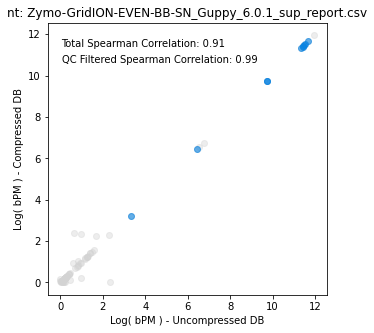

/Users/katrina.kalantar/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


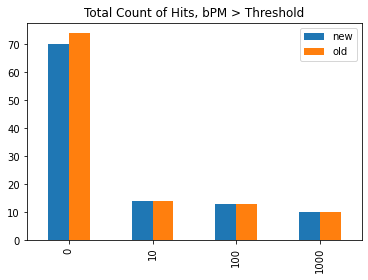

delta_aupr: 0.0
aupr new: 1.0
hello
nanopore-2021_compressed_new_approach
nr
zymo


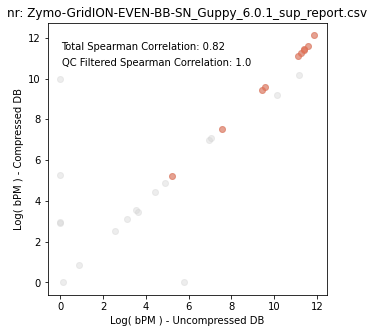

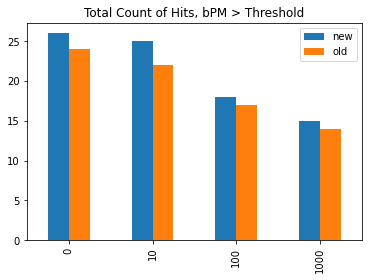

delta_aupr: 0.004640937889046626
aupr new: 0.5390331154788987
hello
BASELINE
nt
zymo


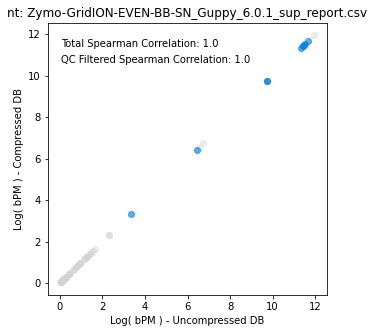

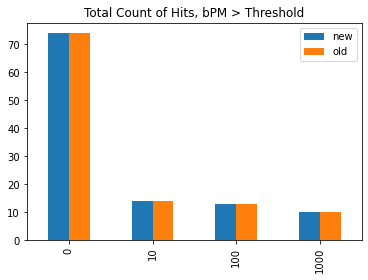

delta_aupr: 0.0
aupr new: 1.0
hello
BASELINE
nr
zymo


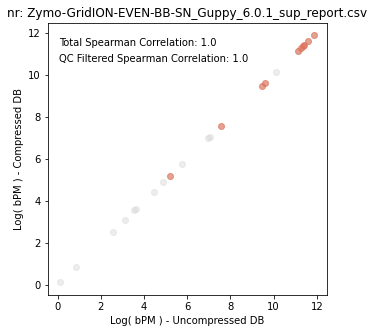

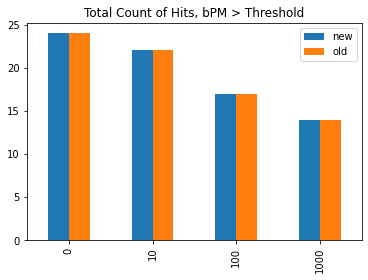

delta_aupr: 0.0
aupr new: 0.534392177589852
hello
{'nt-0.9-1000':       sc_total  pc_total  sc_top  pc_top  sc_total_norm  l2_total      aupr  \
zymo      0.91      0.91    0.99     1.0           0.91  0.001978  0.995384   

      new_taxon_count  old_taxon_count  percent_increase  new_taxon_count_f  \
zymo               70               74             -5.41                 14   

      old_taxon_count_f  percent_increase_f  delta_aupr  delta_l2  \
zymo                 14                 0.0         0.0  0.000031   

      known_sp_prop_old  known_sp_prop_new  delta_prop  aupr_gs_new  \
zymo                  0                  0           0          1.0   

      aupr_gs_old  
zymo          1.0  , 'nr-0.9-1000':       sc_total  pc_total  sc_top  pc_top  sc_total_norm  l2_total      aupr  \
zymo      0.82      0.82     1.0    0.98           0.82  0.082466  0.928792   

      new_taxon_count  old_taxon_count  percent_increase  new_taxon_count_f  \
zymo               26               24  

In [56]:
# INPUT FILES

# This manifest is intended to specify the input OLD v. NEW samples
manifest = {'zymo': {'goldstandard': 'zymo_TRUTH.txt', 'old': 'Zymo-GridION-EVEN-BB-SN_Guppy_6.0.1_sup_report.csv', 'new': 'Zymo-GridION-EVEN-BB-SN_Guppy_6.0.1_sup_report.csv', "known_sp": "XXXX"}}

# This specifies which parameters were used in each set of pipeline runs
metadata_manifest = {
    #'20210122_unclobbered_0-9_1000_31': {'nt': 'nt-0.9-1000', 'nr': 'nr-0.9-1000'},
    'nanopore-2021_compressed_new_approach': {'nt': 'nt-0.9-1000', 'nr': 'nr-0.9-1000'},
    'BASELINE':{'nt':'nt-baseline', 'nr':'nr-baseline'} 
}

# Run through each directory in the metadata manifest (each experiment) and calculate the metrics, formatting based on the relevant parameters

aggregate_metrics_dict = {}

for this_iteration in metadata_manifest.keys():
    
    for db in metadata_manifest[this_iteration].keys(): 
        
        print(this_iteration)
        print(db)
        aggregate_metrics_dict[metadata_manifest[this_iteration][db]] = {}
        
        current_db = db

        prefix_old = "./data/BASELINE/"
        prefix_new = "./data/NEW/" + this_iteration + "/"
        prefix_gs = "./data/GOLD_STANDARD/"

        final_metrics_dict = {}
        for i in manifest.keys():

            print(i)
            old_taxon_counts = prefix_old + manifest[i]["old"]
            new_taxon_counts = prefix_new + manifest[i]["new"]
            gold_standard = prefix_gs + manifest[i]["goldstandard"]
            known_sp = manifest[i]["known_sp"]

            final_metrics_dict[i] = generate_metrics(old_taxon_counts, new_taxon_counts, gold_standard, known_sp, current_db, show_plots = True)

        final_metrics_df = pd.DataFrame.from_dict(final_metrics_dict, orient='index')
        final_metrics_df
        
        aggregate_metrics_dict[metadata_manifest[this_iteration][db]] = final_metrics_df

print(aggregate_metrics_dict)

In [57]:
aggregate_metrics_dict['nt-0.9-1000']

,sc_total,pc_total,sc_top,pc_top,sc_total_norm,l2_total,aupr,new_taxon_count,old_taxon_count,percent_increase,new_taxon_count_f,old_taxon_count_f,percent_increase_f,delta_aupr,delta_l2,known_sp_prop_old,known_sp_prop_new,delta_prop,aupr_gs_new,aupr_gs_old
zymo,0.91,0.91,0.99,1.0,0.91,0.001978,0.995384,70,74,-5.41,14,14,0.0,0.0,0.000031,0,0,0,1.0,1.0


In [58]:
aggregate_metrics_dict['nr-0.9-1000']

,sc_total,pc_total,sc_top,pc_top,sc_total_norm,l2_total,aupr,new_taxon_count,old_taxon_count,percent_increase,new_taxon_count_f,old_taxon_count_f,percent_increase_f,delta_aupr,delta_l2,known_sp_prop_old,known_sp_prop_new,delta_prop,aupr_gs_new,aupr_gs_old
zymo,0.82,0.82,1.0,0.98,0.82,0.082466,0.928792,26,24,8.33,25,22,13.64,0.004641,0.021437,0,0,0,0.539033,0.534392


In [59]:
official_colors = ['#55efc4','#00b894', #greens 
                   '#81ecec','#00cec9', #teals
                   '#74b9ff','#0984e3', #blues
                   '#a29bfe','#6c5ce7', #purples
                   '#ffeaa7','#fdcb6e', #yellows
                   '#fab1a0', '#e17055', #oranges
                   '#ff7675', '#d63031', #reds
                   '#fd79a8', '#e84393', #pinks
                   '#dfe6e9', '#b2bec3', '#636e72', '#2d3436' #greys
                  ]

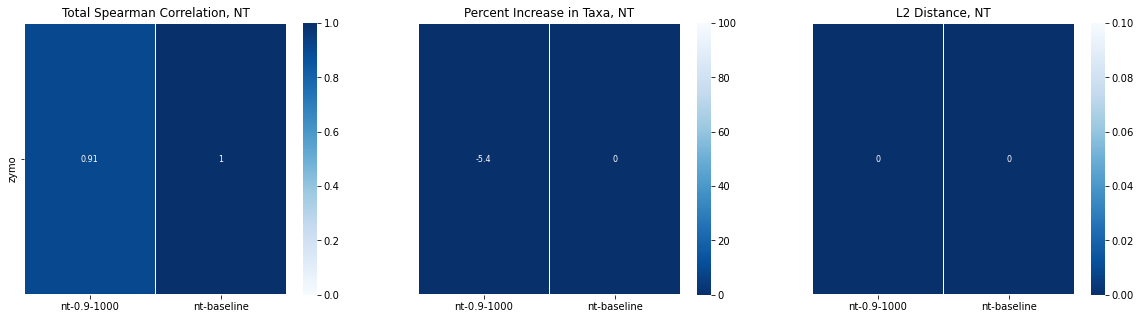

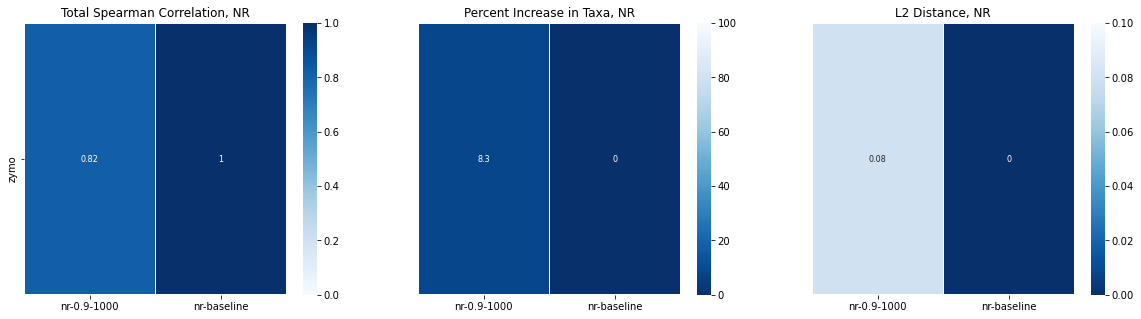

In [60]:
# FIGURE S3 DRAFT - Plot heatmaps for each metric, showing metrics across samples and parameters - FOR ALL PARAMETERS TESTED

column_order_nt = ['nt-0.9-1000', 'nt-baseline'] #'nt-refseq',
column_order_nr = [ 'nr-0.9-1000', 'nr-baseline'] #'nr-refseq', 

def plot_heatmap(input_df, plot_type, this_title):
    
    if plot_type == 'corr':
        this_vmax = 1
        this_vmin = 0
        cpal = sns.color_palette("Blues", as_cmap=True)
    elif plot_type == 'pct':
        this_vmax = 100
        this_vmin = 0 #-100
        cpal = sns.color_palette("Blues_r", as_cmap=True) #"RdBu_r"
    elif plot_type == 'l2':
        this_vmax = .1
        this_vmin = 0
        cpal = sns.color_palette("Blues_r", as_cmap=True)
    elif plot_type == 'aupr':
        this_vmax = 1
        this_vmin = 0
        cpal = sns.color_palette("Blues_r", as_cmap=True)
    
    sns.heatmap(input_df, vmax = this_vmax, vmin = this_vmin, cmap=cpal, linewidths=.5, linecolor='white', annot=True, annot_kws={"size":8})#,figsize=(4,5))
    plt.title(this_title)
    #plt.show()

plt.figure(figsize=(20,5))

# plot nt correlation as heatmap
plt.subplot(1, 3, 1)
nt_corr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_corr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['sc_total'])
nt_corr_df = pd.DataFrame.from_dict(nt_corr_heatmap_data)
plot_heatmap(nt_corr_df[column_order_nt], plot_type='corr', this_title='Total Spearman Correlation, NT')

# plot nt pct_inc as heatmap
plt.subplot(1, 3, 2)
nt_pctinc_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_pctinc_heatmap_data[i] = dict(aggregate_metrics_dict[i]['percent_increase'])        
nt_pctinc_df = pd.DataFrame.from_dict(nt_pctinc_heatmap_data)
plot_heatmap(np.round(nt_pctinc_df[column_order_nt],2), plot_type='pct', this_title='Percent Increase in Taxa, NT')
plt.yticks([])

# plot nt L2 as heatmap
plt.subplot(1, 3, 3)
nt_l2_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_l2_heatmap_data[i] = dict(aggregate_metrics_dict[i]['l2_total'])
nt_l2_df = pd.DataFrame.from_dict(nt_l2_heatmap_data)
plot_heatmap(np.round(nt_l2_df[column_order_nt],2), plot_type='l2', this_title='L2 Distance, NT')
plt.yticks([])

plt.show()


plt.figure(figsize=(20,5))

# plot nr correlation as heatmap
plt.subplot(1, 3, 1)
nr_corr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_corr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['sc_total'])
nr_corr_df = pd.DataFrame.from_dict(nr_corr_heatmap_data)
nr_corr_df
plot_heatmap(nr_corr_df[column_order_nr], plot_type='corr', this_title='Total Spearman Correlation, NR')


# plot nr pct_inc as heatmap
plt.subplot(1, 3, 2)
nr_pctinc_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_pctinc_heatmap_data[i] = dict(aggregate_metrics_dict[i]['percent_increase'])
nr_pctinc_df = pd.DataFrame.from_dict(nr_pctinc_heatmap_data)
plot_heatmap(np.round(nr_pctinc_df[column_order_nr],2), plot_type='pct', this_title='Percent Increase in Taxa, NR')
plt.yticks([])

# plot nr L2 as heatmap
plt.subplot(1, 3, 3)
nr_l2_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_l2_heatmap_data[i] = dict(aggregate_metrics_dict[i]['l2_total'])
        
nr_l2_df = pd.DataFrame.from_dict(nr_l2_heatmap_data)
plot_heatmap(np.round(nr_l2_df[column_order_nr],2), plot_type='l2', this_title='L2 Distance, NR')
plt.yticks([])

plt.show()


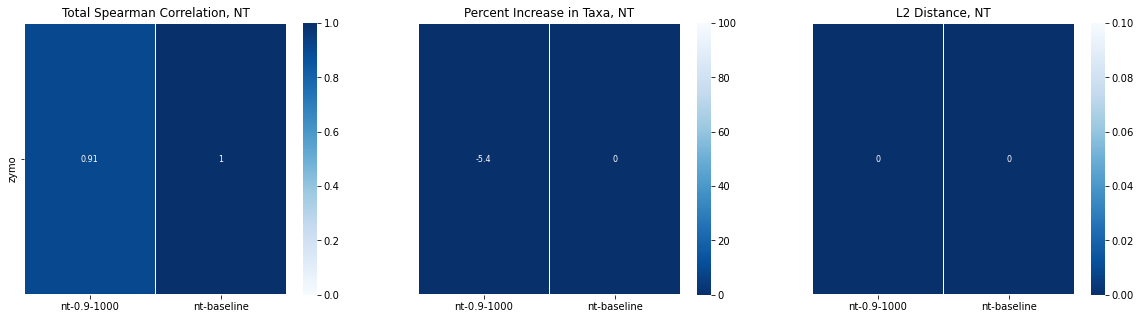

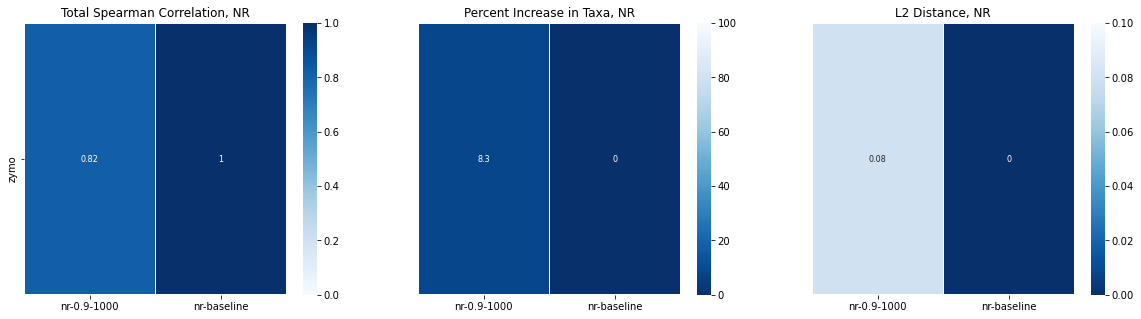

In [61]:
# FIGURE S3 - Plot heatmaps for each metric, showing metrics across samples and parameters

column_order_nt = ['nt-0.9-1000', 'nt-baseline'] #'nt-refseq',
column_order_nr = [ 'nr-0.9-1000', 'nr-baseline'] #'nr-refseq', 

def plot_heatmap(input_df, plot_type, this_title):
    
    if plot_type == 'corr':
        this_vmax = 1
        this_vmin = 0
        cpal = sns.color_palette("Blues", as_cmap=True)
    elif plot_type == 'pct':
        this_vmax = 100
        this_vmin = 0 #-100
        cpal = sns.color_palette("Blues_r", as_cmap=True) #"RdBu_r"
    elif plot_type == 'l2':
        this_vmax = .1
        this_vmin = 0
        cpal = sns.color_palette("Blues_r", as_cmap=True)
    elif plot_type == 'aupr':
        this_vmax = 1
        this_vmin = 0
        cpal = sns.color_palette("Blues_r", as_cmap=True)
    
    sns.heatmap(input_df, vmax = this_vmax, vmin = this_vmin, cmap=cpal, linewidths=.5, linecolor='white', annot=True, annot_kws={"size":8})#,figsize=(4,5))
    plt.title(this_title)
    #plt.show()

plt.figure(figsize=(20,5))

# plot nt correlation as heatmap
plt.subplot(1, 3, 1)
nt_corr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_corr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['sc_total'])
nt_corr_df = pd.DataFrame.from_dict(nt_corr_heatmap_data)
plot_heatmap(nt_corr_df[column_order_nt], plot_type='corr', this_title='Total Spearman Correlation, NT')

# plot nt pct_inc as heatmap
plt.subplot(1, 3, 2)
nt_pctinc_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_pctinc_heatmap_data[i] = dict(aggregate_metrics_dict[i]['percent_increase'])        
nt_pctinc_df = pd.DataFrame.from_dict(nt_pctinc_heatmap_data)
plot_heatmap(np.round(nt_pctinc_df[column_order_nt],2), plot_type='pct', this_title='Percent Increase in Taxa, NT')
plt.yticks([])

# plot nt L2 as heatmap
plt.subplot(1, 3, 3)
nt_l2_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_l2_heatmap_data[i] = dict(aggregate_metrics_dict[i]['l2_total'])
nt_l2_df = pd.DataFrame.from_dict(nt_l2_heatmap_data)
plot_heatmap(np.round(nt_l2_df[column_order_nt],2), plot_type='l2', this_title='L2 Distance, NT')
plt.yticks([])

plt.show()


plt.figure(figsize=(20,5))

# plot nr correlation as heatmap
plt.subplot(1, 3, 1)
nr_corr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_corr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['sc_total'])
nr_corr_df = pd.DataFrame.from_dict(nr_corr_heatmap_data)
nr_corr_df
plot_heatmap(nr_corr_df[column_order_nr], plot_type='corr', this_title='Total Spearman Correlation, NR')


# plot nr pct_inc as heatmap
plt.subplot(1, 3, 2)
nr_pctinc_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_pctinc_heatmap_data[i] = dict(aggregate_metrics_dict[i]['percent_increase'])
nr_pctinc_df = pd.DataFrame.from_dict(nr_pctinc_heatmap_data)
plot_heatmap(np.round(nr_pctinc_df[column_order_nr],2), plot_type='pct', this_title='Percent Increase in Taxa, NR')
plt.yticks([])

# plot nr L2 as heatmap
plt.subplot(1, 3, 3)
nr_l2_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_l2_heatmap_data[i] = dict(aggregate_metrics_dict[i]['l2_total'])
        
nr_l2_df = pd.DataFrame.from_dict(nr_l2_heatmap_data)
plot_heatmap(np.round(nr_l2_df[column_order_nr],2), plot_type='l2', this_title='L2 Distance, NR')
plt.yticks([])

plt.show()


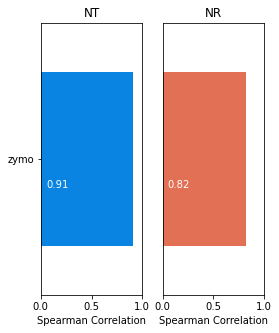

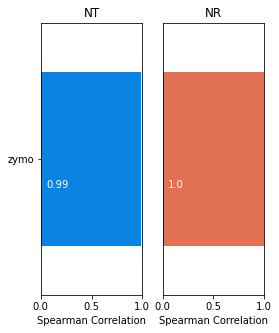

zymo    0.0
Name: delta_aupr, dtype: float64
zymo    0.004641
Name: delta_aupr, dtype: float64


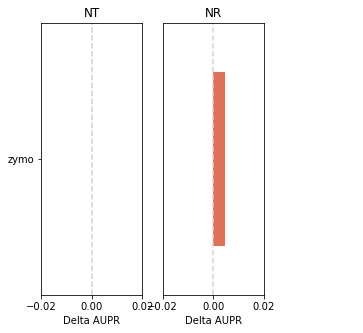

Delta L2
zymo    0.000031
Name: delta_l2, dtype: float64
zymo    0.021437
Name: delta_l2, dtype: float64


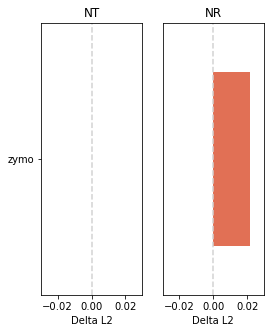

In [62]:
# FIGURE 2A, 2B, and 2C - For a specified parameterization, plot the key metrics to be shown alongside the main text

selected_nt = 'nt-0.9-1000'
selected_nr = 'nr-0.9-1000'

this_data_nt = aggregate_metrics_dict[selected_nt]
#this_data_nt.drop(['norg_13'])
this_data_nr = aggregate_metrics_dict[selected_nr]
#this_data_nr.drop(['norg_13'])



plt.subplot(1, 2, 1)
this_data_nt['sc_total'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(0,1), color=official_colors[5])
plt.xlabel('Spearman Correlation')
plt.title('NT')
for i, v in enumerate(this_data_nt['sc_total']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.subplot(1, 2, 2)
this_data_nr['sc_total'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(0,1), color=official_colors[11])
plt.xlabel('Spearman Correlation')
plt.title('NR')
plt.yticks([])
for i, v in enumerate(this_data_nr['sc_total']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.show()


plt.subplot(1, 2, 1)
this_data_nt['sc_top'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(0,1), color=official_colors[5])
plt.xlabel('Spearman Correlation')
plt.title('NT')
for i, v in enumerate(this_data_nt['sc_top']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.subplot(1, 2, 2)
this_data_nr['sc_top'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(0,1), color=official_colors[11])
plt.xlabel('Spearman Correlation')
plt.title('NR')
plt.yticks([])
for i, v in enumerate(this_data_nr['sc_top']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.show()


plt.subplot(1, 2, 1)
print(this_data_nt['delta_aupr'])
this_data_nt['delta_aupr'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(-.02,.02), color=official_colors[5])
plt.xlabel('Delta AUPR')
plt.title('NT')
plt.axvline(x=0, linestyle='dashed', color = 'lightgrey')
for i, v in enumerate(this_data_nt['delta_aupr']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.subplot(1, 2, 2)
print(this_data_nr['delta_aupr'])
this_data_nr['delta_aupr'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(-.02,.02), color=official_colors[11])
plt.xlabel('Delta AUPR')
plt.title('NR')
plt.yticks([])
plt.axvline(x=0, linestyle='dashed', color = 'lightgrey')
for i, v in enumerate(this_data_nr['delta_aupr']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.show()

plt.subplot(1, 2, 1)
this_data_nt['delta_l2'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(-.03,.03), color = official_colors[5])
plt.xlabel('Delta L2')
plt.title('NT')
plt.axvline(x=0, linestyle='dashed', color = 'lightgrey')
#for i, v in enumerate(this_data_nt['l2_total']):
#    plt.text(0.01, i - .15, str(np.round(v,2)), color='black')

plt.subplot(1, 2, 2)
this_data_nr['delta_l2'].plot(kind='barh', width=.9, figsize=(4,5), xlim=(-.03,.03), color=official_colors[11])
plt.yticks([])
plt.xlabel('Delta L2')
plt.title('NR')
plt.axvline(x=0, linestyle='dashed', color = 'lightgrey')

print("Delta L2")
print(this_data_nt['delta_l2'])
print(this_data_nr['delta_l2'])
plt.show()


#for i, v in enumerate(this_data_nr['l2_total']):
#    plt.text(0.01, i - .15, str(np.round(v,2)), color='black')


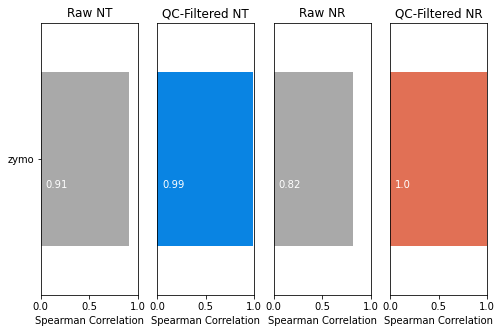

In [63]:

plt.subplot(1, 4, 1)
this_data_nt['sc_total'].plot(kind='barh', width=.9, figsize=(8,5), xlim=(0,1), color='darkgrey')
plt.xlabel('Spearman Correlation')
plt.title('Raw NT')
for i, v in enumerate(this_data_nt['sc_total']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

    
plt.subplot(1, 4, 2)
this_data_nt['sc_top'].plot(kind='barh', width=.9, figsize=(8,5), xlim=(0,1), color=official_colors[5])
plt.xlabel('Spearman Correlation')
plt.title('QC-Filtered NT')
plt.yticks([])
for i, v in enumerate(this_data_nt['sc_top']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

    
plt.subplot(1, 4, 3)
this_data_nr['sc_total'].plot(kind='barh', width=.9, figsize=(8,5), xlim=(0,1), color='darkgrey')
plt.xlabel('Spearman Correlation')
plt.title('Raw NR')
plt.yticks([])
for i, v in enumerate(this_data_nr['sc_total']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')


plt.subplot(1, 4, 4)
this_data_nr['sc_top'].plot(kind='barh', width=.9, figsize=(8,5), xlim=(0,1), color=official_colors[11])
plt.xlabel('Spearman Correlation')
plt.title('QC-Filtered NR')
plt.yticks([])
for i, v in enumerate(this_data_nr['sc_top']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.show()


In [64]:
# Specific analysis comparing the AUPR for gold standard samples with original vs. refseq vs. select compressed version
list_of_values = [aggregate_metrics_dict['nt-baseline']['aupr_gs_new'],
                  #aggregate_metrics_dict['nt-refseq']['aupr_gs_new'],
                  aggregate_metrics_dict['nt-0.9-1000']['aupr_gs_new'],
                  aggregate_metrics_dict['nr-baseline']['aupr_gs_new'],
                  #aggregate_metrics_dict['nr-refseq']['aupr_gs_new'],
                  aggregate_metrics_dict['nr-0.9-1000']['aupr_gs_new']]
results_compared_to_refseq = pd.concat(list_of_values, axis=1)
results_compared_to_refseq.columns = ['nt-baseline', 'nt-0.9-1000', 'nr-baseline', 'nr-0.9-1000'] #'nt-refseq',  'nr-refseq', 
results_compared_to_refseq

,nt-baseline,nt-0.9-1000,nr-baseline,nr-0.9-1000
zymo,1.0,1.0,0.534392,0.539033


In [65]:
# TODO - figure out how to make this printf work! 
# TODO - text says "regardless of sequencing technology" which would require making this whole script compatible with the zymobiomics sample

print("Average Delta AUPR NT: %f, SD = %f" % (np.round(np.mean(this_data_nt['delta_aupr']),3), np.round(np.std(this_data_nt['delta_aupr']), 3)))
print("Average Delta AUPR NR: %f, SD = %f" % (np.round(np.mean(this_data_nr['delta_aupr']),3), np.round(np.std(this_data_nr['delta_aupr']), 3)))


print("Average Delta L2 NT: %f, SD = %f" % (np.round(np.mean(this_data_nt['delta_l2']),3), np.round(np.std(this_data_nt['delta_l2']), 3)))
print("Average Delta L2 NR: %f, SD = %f" % (np.round(np.mean(this_data_nr['delta_l2']),3), np.round(np.std(this_data_nr['delta_l2']), 3)))



print("NT Delta AUPR range: %f - %f" % (np.min(this_data_nt['delta_aupr']), np.max(this_data_nt['delta_aupr'])))
print("NT Delta L2 range: %f - %f" % (np.min(this_data_nt['delta_l2']), np.max(this_data_nt['delta_l2'])))

print("NR Delta AUPR range: %f - %f" % (np.min(this_data_nr['delta_aupr']), np.max(this_data_nr['delta_aupr'])))
print("NR Delta L2 range: %f - %f" % (np.min(this_data_nr['delta_l2']), np.max(this_data_nr['delta_l2'])))



print("(NT) average spearman correlation %f (SD = %f)" % (np.mean(this_data_nt['sc_total']), np.std(this_data_nt['sc_total'])))
print("(NR) average spearman correlation %f (SD = %f)" % (np.mean(this_data_nr['sc_total']), np.std(this_data_nr['sc_total'])))

print("(NT) average QC-filtered spearman correlation %f (SD = %f)" % (np.mean(this_data_nt['sc_top']), np.std(this_data_nt['sc_top'])))
print("(NR) average QC-filtered spearman correlation %f (SD = %f)" % (np.mean(this_data_nr['sc_top']), np.std(this_data_nr['sc_top'])))


print("(NT) average L2 distance = %f (SD = %f)" % (np.mean(this_data_nt['l2_total']), np.std(this_data_nt['l2_total'])))
print("(NR) average L2 distance = %f (SD = %f)" % (np.mean(this_data_nr['l2_total']), np.std(this_data_nt['l2_total'])))
print("L2 distances remained low ( < %f for NT, %f for NR)" % (np.max(this_data_nt['l2_total']), np.max(this_data_nr['l2_total'])))


Average Delta AUPR NT: 0.000000, SD = 0.000000
Average Delta AUPR NR: 0.005000, SD = 0.000000
Average Delta L2 NT: 0.000000, SD = 0.000000
Average Delta L2 NR: 0.021000, SD = 0.000000
NT Delta AUPR range: 0.000000 - 0.000000
NT Delta L2 range: 0.000031 - 0.000031
NR Delta AUPR range: 0.004641 - 0.004641
NR Delta L2 range: 0.021437 - 0.021437
(NT) average spearman correlation 0.910000 (SD = 0.000000)
(NR) average spearman correlation 0.820000 (SD = 0.000000)
(NT) average QC-filtered spearman correlation 0.990000 (SD = 0.000000)
(NR) average QC-filtered spearman correlation 1.000000 (SD = 0.000000)
(NT) average L2 distance = 0.001978 (SD = 0.000000)
(NR) average L2 distance = 0.082466 (SD = 0.000000)
L2 distances remained low ( < 0.001978 for NT, 0.082466 for NR)
